# Exploring Mental Health Discourse on Reddit

This notebook explores public discourse around mental health on Reddit by analyzing posts from the subreddits r/MentalHealth and r/MentalHealthSupport. It covers data collection, preprocessing, topic modeling, sentiment analysis, and classification of posts. The goal is to understand how discussions have evolved over time and to uncover key themes and sentiments within these communities.

### Import Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import transformers
import torch

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import wordnet

from textblob import TextBlob

from datasets import load_dataset

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import gensim
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud

from collections import Counter
from joblib import Parallel, delayed
from gensim import corpora

import string 
from string import punctuation

import os
import datetime
import time
import re
import requests
import random

import praw

# supress warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="wordcloud")

In [2]:
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/samantharivas/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/samantharivas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samantharivas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/samantharivas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/samantharivas/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Connecting to Reddit API

*The code was modified based on resources available at https://github.com/rogerfitz/tutorials/blob/master/subreddit_analysis/0_Setup.ipynb and a tutorial accessed via https://www.youtube.com/watch?v=a3zQdlLwEb4.*

In [3]:
# establish connection with reddit API
reddit = praw.Reddit(
    client_id="81TBuwGeFdL5ZfijNpLxNw",
    client_secret="fn2ztcn8ojr3vewO93h46nZ2YY47mw",
    user_agent="Academic_Winner_5303",
)

#### Obtaining Posts from r/mentalhealth

In [4]:
# specify the subreddit
subreddit_mh = 'MentalHealth'

# fetch posts fromsubreddit
subreddit = reddit.subreddit(subreddit_mh)
word_to_check = "mental health"

In [5]:
for submission in reddit.subreddit('mentalhealth').hot(limit=None):
    print(submission.title)

Men's Mental Health Month
Warning regarding DM's and chatgroups offering "help".
In case no one has told you lately.
I feel like no one has ever cared about me
For people who used to be depressed due to the state of the world/how tough life is in general and gotten better, how did you do it?
I want to be the most important person to someone 
Which mental health illness do you have?
i need support and advice 
Just wanted to share my life 
Problems with sex life and mental health please help. 
Lexapro taking too long to help
The most harmful thing bad parenting can do. 
I can't remember anything before age 10, and I'm 13
I really need to talk to someone
Will I get sent to a mental hospital for this?
My mental health is still plummeting.....
What do you do to cure your sadness ?
Bad thoughts from the past are bugging me 
Feeling gross about my views about romantic relationships
How do I know whether I'm mentally unwell or just a genuinely horrible person?
my friend is gonna kill himself a

Did anyone went to therapy due to their over thinking , what's your experience , advices?
High school graduate in need of help 
Hard to cope on my own
How to live in the real world?
Opinions needed!! Please say something will i ruined my life for rest of my life or not. I feel i cant get good enough never.
What do I do
What do you do when you realize there’s nothing?
I (27F) feel disgusted with myself for wanting to be with my now amazing boyfriend (27M)
I struggle with homicidal ideation, and I think this struggle should be talked about more
I have some problems with my friend now, guys help me
I need some advice in regards to my relationship
My dreams have been ruining my life
What's your honest opinion on people who go out showing healed scars? 
I'm turning 20 this year and I have done nothing with my life
Why do I feel like I cant feel emotions 
I want counseling and therapy
My mental health has ruined my teeth
Emotionally numb?
My thoughts
Feeling Alone
How do I get over Body Dysm

Living too much in the past?
I’m spiraling and don’t know what to do.
Can someone give me a advice preferbly from a female 
Is this SA? 
Psych meds and Consciousness
The brand of the struggler
I just want to draw.
Feeling brave today 
Glimmer / a kid hugged me
Am I the problem if I grew up feeling a deep hatred to my own family?
What should I do if I think I have social anxiety?
What is it called when you never develop mentally past a certain age?
Problems with nostalgia 
In Japan, many girls with self-harm scars have experienced prostitution and sexual violence, but is this universal?
Help me please
How do you know when you probably are genuinely mentally ill?
Is this too much of paranoia? Whenever I want to order food online, this is the mental struggle I go through.
To/for those who don't value love
I made an attempt on my life a few weeks ago. Ever since then I've felt lost.
Brother involuntarily admitted
Just feel so busy and getting all the blame for everything, so what do you do

Am I screwed if I missed out on close childhood friendship and other youthful things?
I did something stupid and I could use "there there" 
I'm worried about my daughter
Just very confused, tips, advice, stories, thoughts
I don’t know whether I need to be tested further medically? Can someone clear this up?
so distressed i physically cant do anything anymore
What are some resources I can use to better my mental health ?
No hopes left
Need some really good advices
A predator relative ruined the way I see things and I have no clue what to do.
insecurity causing mental health problems affecting quality of life 
I'm a failure
why do I feel like I dont deserve anything
Wanting to be someone else
Book recommendations in dealing with the flight response
I destroyed my friendship with my best friend, relapsed, and then made everything in my life a thousand times worse.
Working and my mental health have never been friends
Validation
worried about someone’s mental health
Can "sundowning" happen 

I need some music suggestions.
Ocd/adhd/rumination 
Anti anxiety medication?
I Am Supposed To Be Happy Right Now...
ADHD/pure OCD/excitement OCD
Does anyone else have a constant, senseless feeling of embarrassment?
I need help with perfectionism 
I wish I was different
I feel like I am being judged at every given point in my life!!!
Made a mistake at work
Feeling lonely, depressed, and with intrusive thoughts about the past
Girlfriend sleepwalking, tryed to run away at night, what should i do? 
I think I’m going to start screaming in my car
Overlap between adhd hyperactivity and depression
Returned from 6 months backpacking. Struggling to figure out where I fit in. How to overcome?
What should I do?
Acute Metabolic Encephalopathy
Developing Dementia.
Random conversation 
Repeated Dreams of talking to "Myself"
I'm so lost and so tired, it's hard to do anything. (SA, SH, attempted suicide)
How can I stop feeling anxious and calm my racing thoughts down? I feel anxious all the time and ca

In [6]:
subreddit=reddit.subreddit("mentalhealth")
subreddit.over18

False

In [7]:
subreddit.subscribers

469074

In [8]:
subreddit.__dict__

{'display_name': 'mentalhealth',
 '_reddit': <praw.reddit.Reddit at 0x7fea2ae2ec10>,
 '_fetched': True,
 '_path': 'r/mentalhealth/',
 'user_flair_background_color': None,
 'submit_text_html': '<!-- SC_OFF --><div class="md"><p>All promotional, survey, research study, or business posts require moderator approval. Please message a moderator to check if your post is suitable. Avoid posting direct links without some context.</p>\n</div><!-- SC_ON -->',
 'restrict_posting': True,
 'user_is_banned': None,
 'free_form_reports': True,
 'wiki_enabled': True,
 'user_is_muted': None,
 'user_can_flair_in_sr': None,
 'header_img': None,
 'title': 'Mental Health',
 'allow_galleries': False,
 'icon_size': None,
 'primary_color': '#005ba1',
 'active_user_count': 48,
 'icon_img': '',
 'display_name_prefixed': 'r/mentalhealth',
 'accounts_active': 48,
 'public_traffic': False,
 'subscribers': 469074,
 'user_flair_richtext': [],
 'name': 't5_2qirg',
 'quarantine': False,
 'hide_ads': False,
 'prediction_

In [9]:
# define function to fetch posts from subreddit ('MentalHealthSupport')
def fetch_posts(subreddit, category='hot', limit=None):
    if category == 'top':
        posts = subreddit.top(time_filter='year', limit=limit)
    elif category == 'rising':
        posts = subreddit.rising(limit=limit)
    elif category == 'new':
        posts = subreddit.new(limit=limit)
    else:
        posts = subreddit.hot(limit=limit)
    
    rows = []
    for submission in posts:
        row = {
            'title': submission.title,
            'score': submission.score,
            'upvote_ratio': submission.upvote_ratio,
            'created_utc': submission.created_utc,
            'selftext': submission.selftext,
            'subreddit': submission.subreddit,
            'author': str(submission.author),
            'media_only': submission.media_only,
            'permalink': submission.permalink,
            'num_comments': submission.num_comments
        }
        rows.append(row)
    
    return pd.DataFrame(rows)

In [10]:
mental_health_top = fetch_posts(subreddit, category='top')
mental_health_hot = fetch_posts(subreddit, category='hot')
mental_health_rising = fetch_posts(subreddit, category='rising')
mental_health_new = fetch_posts(subreddit, category='new')

In [11]:
# concatenate dataframes
mental_health_df = pd.concat([mental_health_top,
                               mental_health_hot, 
                               mental_health_rising, 
                               mental_health_new],
                              ignore_index=True)

# drop duplicates
mental_health_df = mental_health_df.drop_duplicates()

In [12]:
mental_health_df['upvotes']=mental_health_df['score']/mental_health_df['upvote_ratio']
mental_health_df['downvotes']=mental_health_df['upvotes']-mental_health_df['score']
mental_health_df['upvotes/subscribers']=mental_health_df['upvotes']/subreddit.subscribers

# convert created_utc to datetimr format 
mental_health_df['created_utc'] = pd.to_datetime(mental_health_df['created_utc'], unit='s')

mental_health_df.sample(5)

,title,score,upvote_ratio,created_utc,selftext,subreddit,author,media_only,permalink,num_comments,upvotes,downvotes,upvotes/subscribers
1293,Advagen Pharma Clonazepam experience,0,0.50,2024-06-15 20:51:52,I'm writing this out of sheer desperation beca...,mentalhealth,is_ananasik,False,/r/mentalhealth/comments/1dgrbnx/advagen_pharm...,0,0.000000,0.000000,0.000000
138,What helps you when you’re feeling suicidal?,187,0.98,2023-10-14 03:56:39,Been having a pretty rough time and would love...,mentalhealth,None,False,/r/mentalhealth/comments/177gucu/what_helps_yo...,232,190.816327,3.816327,0.000407
382,Terminated after informing managers of my ment...,85,0.97,2023-08-14 21:01:29,I was terminated 2 days after texting my manag...,mentalhealth,Effective_Fun_7863,False,/r/mentalhealth/comments/15r6y1y/terminated_af...,30,87.628866,2.628866,0.000187
1809,I need to get my extreme feelings for someone ...,1,1.00,2024-06-13 13:54:29,Last year I (17F) had a small crush on a guy (...,mentalhealth,Cooldude4evaa,False,/r/mentalhealth/comments/1dezkek/i_need_to_get...,2,1.000000,0.000000,0.000002
231,What is the kindest thing someone has done for...,137,1.00,2024-01-23 00:47:32,"What is the (kindest, most helpful, most memor...",mentalhealth,GoodOhm,False,/r/mentalhealth/comments/19dblqh/what_is_the_k...,103,137.000000,0.000000,0.000292


In [13]:
mental_health_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2030 entries, 0 to 2897
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   title                2030 non-null   object        
 1   score                2030 non-null   int64         
 2   upvote_ratio         2030 non-null   float64       
 3   created_utc          2030 non-null   datetime64[ns]
 4   selftext             2030 non-null   object        
 5   subreddit            2030 non-null   object        
 6   author               2030 non-null   object        
 7   media_only           2030 non-null   bool          
 8   permalink            2030 non-null   object        
 9   num_comments         2030 non-null   int64         
 10  upvotes              2030 non-null   float64       
 11  downvotes            2030 non-null   float64       
 12  upvotes/subscribers  2030 non-null   float64       
dtypes: bool(1), datetime64[ns](1), fl

In [14]:
# create directory to store data 
os.makedirs('data', exist_ok=True)

# create csv 
mental_health_df.to_csv('data/mental_health_posts.csv', index=False)

#### Obtaining Posts  from r/MentalHealthSupport 

In [15]:
# specify the subreddit
subreddit_mhs = 'MentalHealthSupport'

# fetch posts fromsubreddit
subreddit = reddit.subreddit(subreddit_mhs)
word_to_check = "mental health"

In [16]:
for submission in reddit.subreddit('mentalhealthsupport').hot(limit=None):
    print(submission.title)

I have an appointment with the local community mental health but I'm scared to go as last time they put me in hospital what do I do to be less anxious about it and how do I keep myself calm during the appointment any ideas that others find helpful please
Is it time to change therapists ?
Seeking Advice on making sense on what I need
Reconciling with existential thoughts.
Is life not meant for me?
SOS...
Seeing therapist
How do you work through your insecurities?
Mental Health and Being a Parent. 
Easiest method to cleaning up my room without completely overwhelming myself 
My teeth are rotting out of my head and I don't know what to do.
Fed up from my thoughts
So done with everything
Help
Is it ok to hate being human
Always feel that I'm sick...plz someone help with this
Some advice and support would be great rn
How to live irl?
i feel like i have schizophrenia
What’s wrong with me?
Making up memories 
AAAA
Is it bad that I can't feel happy for anyone else?
How to deal with feeling lik

Did I overreact? (Contains threats of SH!!)
I am noticing the letter 'D' in words.
Today is such a hard day to exist so I wrote this poem. If anyone else feels lost and helpless you are not alone. 
I hate college
No one cares 
Life is cruel 
I can’t communicate to my family about my problems.
I don't know who I am
What to do next
I feel like giving up. Please help.
I don't know what I am? 
My mental sexual health is just wrong
I don’t know what to do anymore
I feel like I'm going insane
What did you do differently that gives you cognitive benefits and enhanced motivation and mood/less anxiety?
Help moving on from school
How do I tell my psychiatrist I’ve possibly become dependent on benzos? 
How do I stop clenching my teeth when I’m relaxed or meditating?
What’s wrong with me?
Ive lost so much and been abused from 2 to now 15 considering becoming the real red hood and i think that i should but it would also mean commiting a lot of crime people have pointed out that i might need theripy

Dad said hurtful things about me getting cheated on by ex bf
Regret spending money on expensive unnecessary things
urgent situation advice PLEASE idk what to do i’m so overwhelmed. 🧍🏼😃🤡.
I wish my father treats me well.
I'm tired of being kind
I have no thoughts
I think the internet plus loneliness is making me really depressed and I don't know how to fix it
I don’t know what to do 
I can't take the way I look anymore 
Struggling to find a support system 
Everything is a blur
Alone
I'm suicidal and this is my last attempt to seek help
my 18F girlfriend has become more and more depressed and she wont tell me 18F why. How can i support her without feeling too pushy?
Idk what to put here but childhood issues
Hi sorry in advance if this is all over the place. 
Why do I even try?
Any advice on stopping/reducing bad thoughts?
I hate myself
I'm taking antidepressant pills without a doctor's consultation. 
I feel so down 
i am losing it 
so scared, i feel like i might not meet my grade require

i just want to give up now
Advice needed. 
I feel the future is dark and bleak
I don't know how to get better. 
Mental Health
Idk atp
It says,Grief doesn't go away it changes you!
Intrusive Thoughts
A few things I have learned 
How do you go on when both your parents are depressed?
Need advice
In a very bad place
Cranky and procrastinating
I’m 13 and depressed
Why do I rarely cry?
I was told I have Bipolar “tendencies” and Im not sure what to make of it…
To whom it may concern.
Adjustment Disorder
Am I alright
Possible withdrawal symptoms? (Ssri’s)
I had a psychiatric assessment today and I was diagnosed with “symptoms of BPD, but definetly not BPD.” Can someone explain this? 
Help. Prob need to go to mental hospital soon and terrified.
Helpme
Getting over stigma or getting help
I’m tired of feeling like this. What can I do? 
I’m drowning
Made appt to go back on meds, feeling like a failure
I am mentally exhausted and I need advice
How can I support my severely depressed partner?
I nee

If my message is delivered
i really need to vent 
I'm loseing it again 
Scar acceptance
Friend invited everyone except for me
I don’t even understand what stage of life I’m in. 
19F, desperately need to vent
I dont think I can never have a normal sex life again...
Torn about my original method of taking my life not being viable
How do I deal with living with my conspiracy theorist mother
24F need help to understand depression and anxiety 
Parasocial and Conflict Seeking
Is it normal to not react anymore?
Family member suffering from severe OCD from past 15 years and refuses counseling. 
I don't know what to do anymore.
I dont know what to do w my life
Stress Advise
Is what I am doing even right?
Rant because I feel a little helpless and burdened...
How do I get out of fear of failure? Need suggestions.
Alone and don’t know what to do
34M, relatively poor, and haven't been in a relationship in 11 years
Help
Sad and happy in one day? 
Another lost soul, any advice?
Is this normal?
i cant

In [17]:
subreddit=reddit.subreddit('mentalhealthsupport')
subreddit.over18

False

In [18]:
subreddit.subscribers

46299

In [19]:
subreddit.__dict__

{'display_name': 'MentalHealthSupport',
 '_reddit': <praw.reddit.Reddit at 0x7fea2ae2ec10>,
 '_fetched': True,
 '_path': 'r/MentalHealthSupport/',
 'user_flair_background_color': None,
 'submit_text_html': '<!-- SC_OFF --><div class="md"><p>Please provide context to links since they require moderator approval. Promotional posts are not permitted.  Message the moderators if you have any query. Make sure your post follows the rules.</p>\n\n<p>This subreddit is optimized for the new Reddit redesign and official app. Please use the newer design to enjoy the subreddit to its fullest, thank you!</p>\n</div><!-- SC_ON -->',
 'restrict_posting': True,
 'user_is_banned': None,
 'free_form_reports': True,
 'wiki_enabled': True,
 'user_is_muted': None,
 'user_can_flair_in_sr': None,
 'header_img': None,
 'title': 'Mental Health Support & Azal',
 'allow_galleries': False,
 'icon_size': None,
 'primary_color': '#2a4fd5',
 'active_user_count': 3,
 'icon_img': '',
 'display_name_prefixed': 'r/MentalH

In [20]:
# define function to fetch posts from subreddit ('MentalHealthSupport')
def fetch_posts(subreddit, category='hot', limit=None):
    if category == 'top':
        posts = subreddit.top(time_filter='year', limit=limit)
    elif category == 'rising':
        posts = subreddit.rising(limit=limit)
    elif category == 'new':
        posts = subreddit.new(limit=limit)
    else:
        posts = subreddit.hot(limit=limit)
    
    rows = []
    for submission in posts:
        row = {
            'title': submission.title,
            'score': submission.score,
            'upvote_ratio': submission.upvote_ratio,
            'created_utc': submission.created_utc,
            'selftext': submission.selftext,
            'subreddit': submission.subreddit,
            'author': str(submission.author),
            'media_only': submission.media_only,
            'permalink': submission.permalink,
            'num_comments': submission.num_comments
        }
        rows.append(row)
    
    return pd.DataFrame(rows)

In [21]:
mental_health_support_top = fetch_posts(subreddit, category='top')
mental_health_support_hot = fetch_posts(subreddit, category='hot')
mental_health_support_rising = fetch_posts(subreddit, category='rising')
mental_health_support_new = fetch_posts(subreddit, category='new')

In [22]:
# concatenate dataframes
mental_health_support_df = pd.concat([mental_health_support_top, 
                                      mental_health_support_hot, 
                                      mental_health_support_rising, 
                                      mental_health_support_new], 
                                     ignore_index=True)

# drop duplicates
mental_health_support_df = mental_health_support_df.drop_duplicates()

In [23]:
mental_health_support_df.head()

,title,score,upvote_ratio,created_utc,selftext,subreddit,author,media_only,permalink,num_comments
0,I feel hopeless.,157,0.99,1.709293e+09,"Hi, I’m 24F. I stay home 24/7 , everyday. I do...",MentalHealthSupport,Odd-View-667,False,/r/MentalHealthSupport/comments/1b3s6ad/i_feel...,154
1,What changes your negative thoughts/ has made ...,45,0.99,1.709444e+09,I am learning that affirmations and the like c...,MentalHealthSupport,Bananasloog1998,False,/r/MentalHealthSupport/comments/1b59lzz/what_c...,21
2,what is the point of living?,44,0.93,1.709354e+09,\ncontent warning for suicide.\n\n\n\nI dont u...,MentalHealthSupport,penjamincranklin,False,/r/MentalHealthSupport/comments/1b4fkko/what_i...,24
3,I need a hug,25,0.95,1.709557e+09,I wanna end me.,MentalHealthSupport,Positive-Parthlow,False,/r/MentalHealthSupport/comments/1b6a8vz/i_need...,26
4,What are you like after a hug,21,0.97,1.709738e+09,If I hug someone I just try my best not to cry...,MentalHealthSupport,itsRileyigitbanned,False,/r/MentalHealthSupport/comments/1b8299d/what_a...,17


In [24]:
# calculate upvotes and downvotes
mental_health_support_df['upvotes']=mental_health_support_df['score']/mental_health_support_df['upvote_ratio']
mental_health_support_df['downvotes']=mental_health_support_df['upvotes']-mental_health_support_df['score']
mental_health_support_df['upvotes/subscribers']=mental_health_support_df['upvotes']/subreddit.subscribers

# convert 'created_utc' to proper format 
mental_health_support_df['created_utc'] = pd.to_datetime(mental_health_support_df['created_utc'], unit='s')

mental_health_support_df.sample(5)

,title,score,upvote_ratio,created_utc,selftext,subreddit,author,media_only,permalink,num_comments,upvotes,downvotes,upvotes/subscribers
236,I’m done.,5,1.0,2024-03-14 01:33:56,I have nothing I feel like he’s sucking out my...,MentalHealthSupport,VeterinarianOk1540,False,/r/MentalHealthSupport/comments/1be96sq/im_done/,2,5.0,0.0,0.000108
987,Should i kill myself?,1,1.0,2024-06-12 23:29:48,**Should i kill myself?**\n\n \nI have never ...,MentalHealthSupport,Greedy-Chart-6268,False,/r/MentalHealthSupport/comments/1dektge/should...,0,1.0,0.0,0.000022
1644,am i selfish for this?,1,1.0,2024-05-20 13:04:44,hi guys i am an 18yo from algeria and one day ...,MentalHealthSupport,The_Skull_fr,False,/r/MentalHealthSupport/comments/1cwf3go/am_i_s...,0,1.0,0.0,0.000022
1577,Possible withdrawal symptoms? (Ssri’s),1,1.0,2024-05-23 02:43:11,"First off, some discussions in here that could...",MentalHealthSupport,Zippy_346,False,/r/MentalHealthSupport/comments/1cyie8f/possib...,2,1.0,0.0,0.000022
46,I lost everything...,9,1.0,2024-03-19 16:50:37,I (33 M) got out of prison in 2016 and worked ...,MentalHealthSupport,suedii,False,/r/MentalHealthSupport/comments/1biozbq/i_lost...,4,9.0,0.0,0.000194


In [25]:
# create directory 
output_dir = 'data'
os.makedirs(output_dir, exist_ok=True)

# create csv 
mental_health_support_df.to_csv('data/mental_health_support_posts.csv', index=False)

In [26]:
mental_health_support_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1915 entries, 0 to 2814
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   title                1915 non-null   object        
 1   score                1915 non-null   int64         
 2   upvote_ratio         1915 non-null   float64       
 3   created_utc          1915 non-null   datetime64[ns]
 4   selftext             1915 non-null   object        
 5   subreddit            1915 non-null   object        
 6   author               1915 non-null   object        
 7   media_only           1915 non-null   bool          
 8   permalink            1915 non-null   object        
 9   num_comments         1915 non-null   int64         
 10  upvotes              1915 non-null   float64       
 11  downvotes            1915 non-null   float64       
 12  upvotes/subscribers  1915 non-null   float64       
dtypes: bool(1), datetime64[ns](1), fl

#### Combine Dataframes (r/MentalHealth and  r/MentalHealthSupport)

In [27]:
# combine both df into one
df = pd.concat([mental_health_support_df, 
                mental_health_df],
               ignore_index=True)

In [28]:
# create csv 
df.to_csv('data/reddit_posts.csv', index=False)

In [29]:
df.info()

df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3945 entries, 0 to 3944
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   title                3945 non-null   object        
 1   score                3945 non-null   int64         
 2   upvote_ratio         3945 non-null   float64       
 3   created_utc          3945 non-null   datetime64[ns]
 4   selftext             3945 non-null   object        
 5   subreddit            3945 non-null   object        
 6   author               3945 non-null   object        
 7   media_only           3945 non-null   bool          
 8   permalink            3945 non-null   object        
 9   num_comments         3945 non-null   int64         
 10  upvotes              3945 non-null   float64       
 11  downvotes            3945 non-null   float64       
 12  upvotes/subscribers  3945 non-null   float64       
dtypes: bool(1), datetime64[ns](1), fl

,title,score,upvote_ratio,created_utc,selftext,subreddit,author,media_only,permalink,num_comments,upvotes,downvotes,upvotes/subscribers
3722,I often get thoughts on harming myself but als...,1,1.00,2024-06-13 14:10:33,"The title says it all, I want to commit suicid...",mentalhealth,VironY__,False,/r/mentalhealth/comments/1dezxt7/i_often_get_t...,0,1.000000,0.000000,0.000002
3751,People on the internet need to understand this...,3,0.80,2024-06-13 04:31:02,"You can hop on reddit, get on a burner account...",mentalhealth,Human_Original_3759,False,/r/mentalhealth/comments/1deqiwc/people_on_the...,1,3.750000,0.750000,0.000008
1096,I’m scared and feel absent,1,1.00,2024-06-09 00:05:24,"I’m scared, and u have this dangerous overwhel...",MentalHealthSupport,oatmealjar,False,/r/MentalHealthSupport/comments/1dbgkss/im_sca...,0,1.000000,0.000000,0.000022
3793,How do I heal from my childhood trauma?,4,0.84,2024-06-12 21:24:02,"To start, I’m a 25 year old woman and I have a...",mentalhealth,AkAElena,False,/r/mentalhealth/comments/1dehzil/how_do_i_heal...,3,4.761905,0.761905,0.000010
411,Help?,3,0.72,2024-03-11 19:27:00,I’ve been in therapy and on medications for ar...,MentalHealthSupport,IceCremeEyes,False,/r/MentalHealthSupport/comments/1bcbt2x/help/,2,4.166667,1.166667,0.000090


### Text Preprocessing (Tokenization and Normalization)

In [30]:
# tokenization/normalization 
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [31]:
# apply preprocessing to 'selftext'
df['tokens'] = df['selftext'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])

In [32]:
# descriptive statistics
numerical_stats = df.describe()
token_count_stats = df['tokens'].describe()

# most common words
all_tokens = [token for tokens in df['tokens'] for token in tokens]
fdist = FreqDist(all_tokens)
most_common_words = fdist.most_common(10)

# output statistics for combined df 
print("Numerical Statistics:\n", numerical_stats)
print("\nToken Count Statistics:\n", token_count_stats)
print("\nMost Common Words:\n", most_common_words)

Numerical Statistics:
              score  upvote_ratio  num_comments      upvotes    downvotes  \
count  3945.000000   3945.000000   3945.000000  3945.000000  3945.000000   
mean     30.190368      0.962631     17.510266    31.693610     1.503243   
std      72.411462      0.085814     43.340425    75.510455     4.787981   
min       0.000000      0.260000      0.000000     0.000000     0.000000   
25%       1.000000      0.970000      0.000000     1.000000     0.000000   
50%       2.000000      1.000000      1.000000     2.000000     0.000000   
75%      31.000000      1.000000     13.000000    33.333333     0.813953   
max     924.000000      1.000000    616.000000   942.857143    61.487179   

       upvotes/subscribers  
count          3945.000000  
mean              0.000095  
std               0.000170  
min               0.000000  
25%               0.000015  
50%               0.000040  
75%               0.000111  
max               0.003425  

Token Count Statistics:
 count

Based on the descriptive statistics provided, we have opted to analyze each subreddit separately for r/MentalHealth and r/MentalHealthSupport. This approach allows for a more focused exploration of each subreddit's unique trends and characteristics. By focusing individually on each subreddit, we can gain deeper insights into specific trends within each subreddit.

In [33]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if isinstance(text, str):
        tokens = word_tokenize(text.lower())
        return [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    else:
        return []

# apply preprocessing to 'selftext' in both df
mental_health_support_df['tokens'] = Parallel(n_jobs=-1)(delayed(preprocess_text)(text) for text in mental_health_support_df['selftext'])
mental_health_df['tokens'] = Parallel(n_jobs=-1)(delayed(preprocess_text)(text) for text in mental_health_df['selftext'])

# function for analyzing subreddits
def analyze_subreddit(subreddit_df):
    numerical_stats = subreddit_df.describe()
    token_count_stats = subreddit_df['tokens'].apply(len).describe()
    all_tokens = [token for tokens in subreddit_df['tokens'] for token in tokens]
    most_common_words = Counter(all_tokens).most_common(10)
    return numerical_stats, token_count_stats, most_common_words

# sentiment analysis functions
def get_sentiment_category(sentiment):
    if sentiment['compound'] > 0:
        return 'positive'
    elif sentiment['compound'] < 0:
        return 'negative'
    else:
        return 'neutral'

def analyze_sentiments(subreddit_df):
    sid = SentimentIntensityAnalyzer()
    subreddit_df['sentiment'] = subreddit_df['selftext'].apply(lambda x: sid.polarity_scores(x) if isinstance(x, str) else {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0})
    subreddit_df['sentiment_category'] = subreddit_df['sentiment'].apply(get_sentiment_category)
    sentiment_stats = subreddit_df['sentiment'].apply(lambda x: x['compound']).describe()
    sentiment_category_counts = subreddit_df['sentiment_category'].value_counts()
    return sentiment_stats, sentiment_category_counts

# function to generate word cloud
def generate_word_cloud(tokens, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(tokens))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# topic modeling function
def topic_modeling(tokens_list, num_topics=5):
    dictionary = corpora.Dictionary(tokens_list)
    corpus = [dictionary.doc2bow(tokens) for tokens in tokens_list]
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)
    topics = lda_model.print_topics(num_words=10)
    return topics

# time series plot function
def plot_time_series(subreddit_df, title):
    subreddit_df['created_utc'] = pd.to_datetime(subreddit_df['created_utc'], unit='s')
    subreddit_df.set_index('created_utc', inplace=True)
    monthly_counts = subreddit_df.resample('M').size()
    monthly_counts.plot(figsize=(10, 5), title=title)
    plt.ylabel('Number of Posts')
    plt.show()

### Descriptive Statistics 

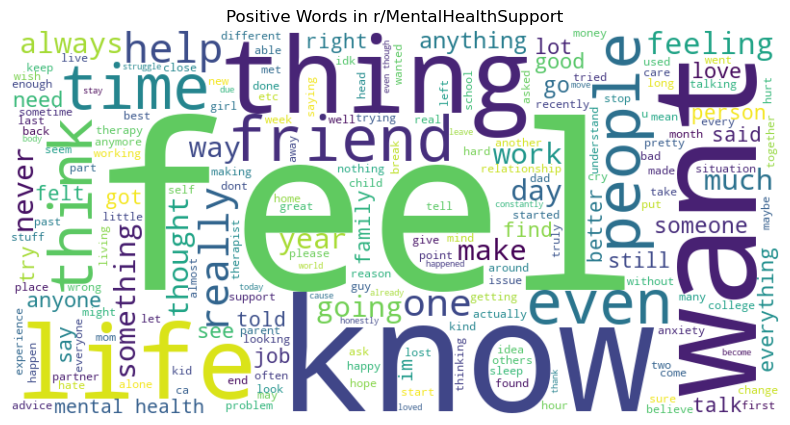

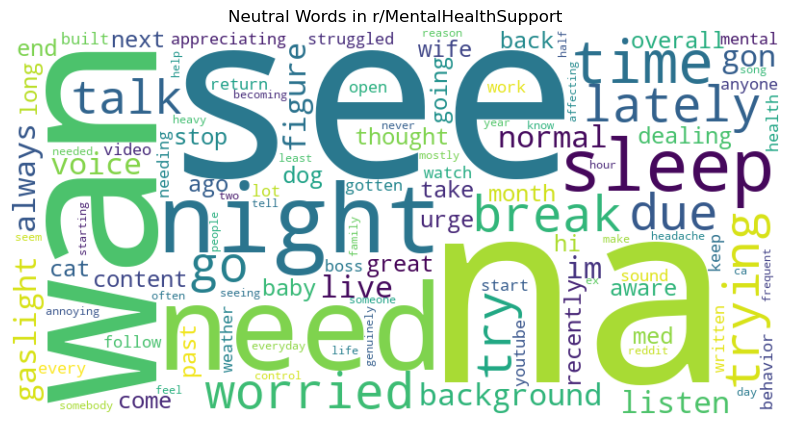

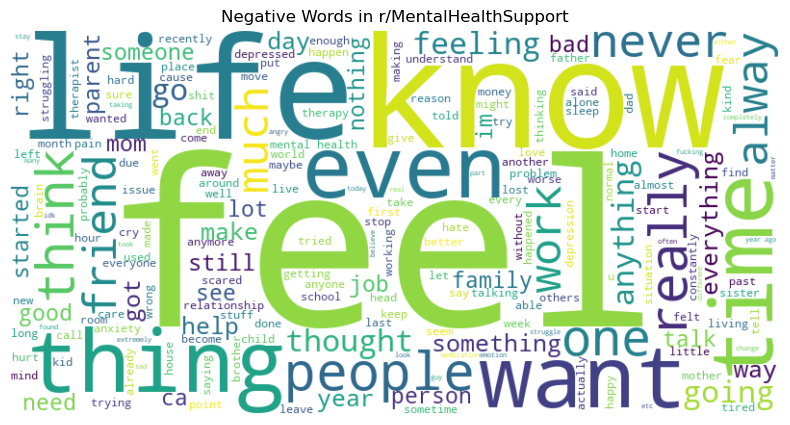

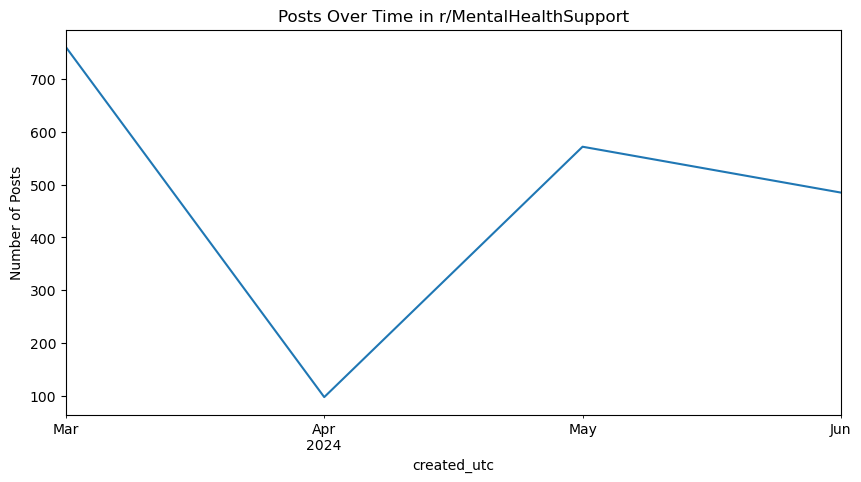


Descriptive Statistics for r/MentalHealthSupport:
Numerical Statistics:
              score  upvote_ratio  num_comments      upvotes    downvotes  \
count  1915.000000   1915.000000   1915.000000  1915.000000  1915.000000   
mean      2.823499      0.971922      2.152480     2.952593     0.129094   
std       4.783415      0.077039      5.371831     4.913038     0.357159   
min       0.000000      0.500000      0.000000     0.000000     0.000000   
25%       1.000000      1.000000      0.000000     1.000000     0.000000   
50%       2.000000      1.000000      0.000000     2.000000     0.000000   
75%       3.000000      1.000000      2.000000     3.000000     0.000000   
max     157.000000      1.000000    154.000000   158.585859     3.311828   

       upvotes/subscribers  
count          1915.000000  
mean              0.000064  
std               0.000106  
min               0.000000  
25%               0.000022  
50%               0.000043  
75%               0.000065  
max      

In [34]:
# r/MentalHealthSupport subreddit
mental_health_support_numerical_stats, mental_health_support_token_count_stats, mental_health_support_common_words = analyze_subreddit(mental_health_support_df)
mental_health_support_sentiment_stats, mental_health_support_sentiment_category_counts = analyze_sentiments(mental_health_support_df)
mental_health_support_topics = topic_modeling(mental_health_support_df['tokens'].tolist())

# word cloud for r/MentalHealthSupport subreddit
positive_words = [token for tokens, sentiment in zip(mental_health_support_df['tokens'], mental_health_support_df['sentiment_category']) if sentiment == 'positive' for token in tokens]
neutral_words = [token for tokens, sentiment in zip(mental_health_support_df['tokens'], mental_health_support_df['sentiment_category']) if sentiment == 'neutral' for token in tokens]
negative_words = [token for tokens, sentiment in zip(mental_health_support_df['tokens'], mental_health_support_df['sentiment_category']) if sentiment == 'negative' for token in tokens]

generate_word_cloud(positive_words, "Positive Words in r/MentalHealthSupport")
generate_word_cloud(neutral_words, "Neutral Words in r/MentalHealthSupport")
generate_word_cloud(negative_words, "Negative Words in r/MentalHealthSupport")

# time series analysis for r/MentalHealthSupport subreddit
plot_time_series(mental_health_support_df, "Posts Over Time in r/MentalHealthSupport")

# statistics for r/MentalHealthSupport subreddit
print("\nDescriptive Statistics for r/MentalHealthSupport:")
print("Numerical Statistics:\n", mental_health_support_numerical_stats)
print("\nToken Count Statistics:\n", mental_health_support_token_count_stats)
print("\nMost Common Words:\n", mental_health_support_common_words)
print("\nSentiment Statistics:\n", mental_health_support_sentiment_stats)
print("\nSentiment Category Counts:\n", mental_health_support_sentiment_category_counts)

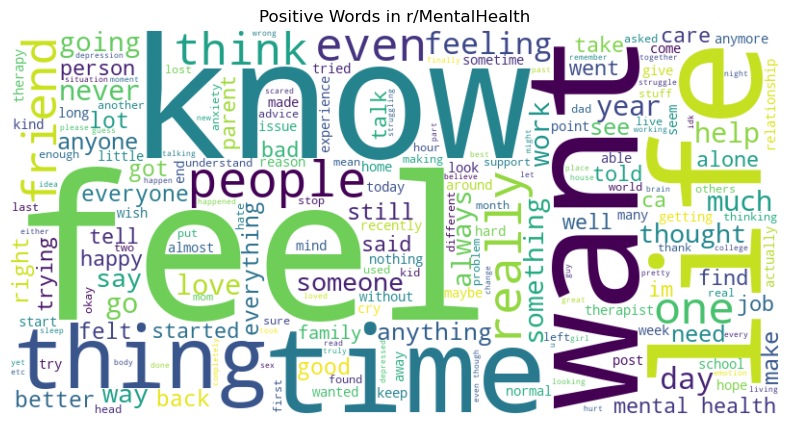

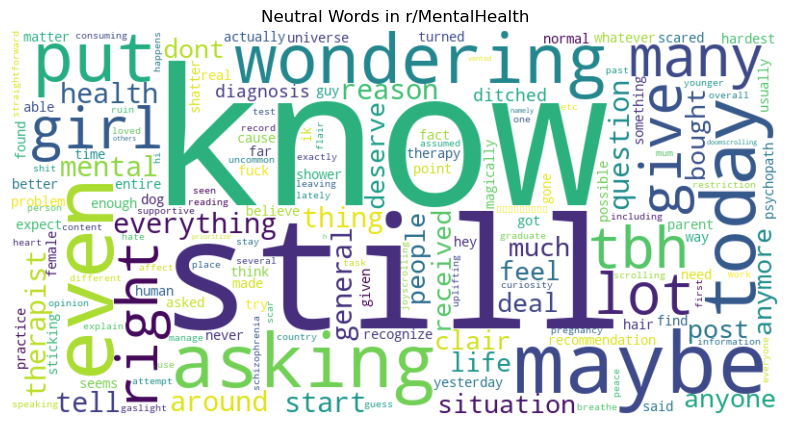

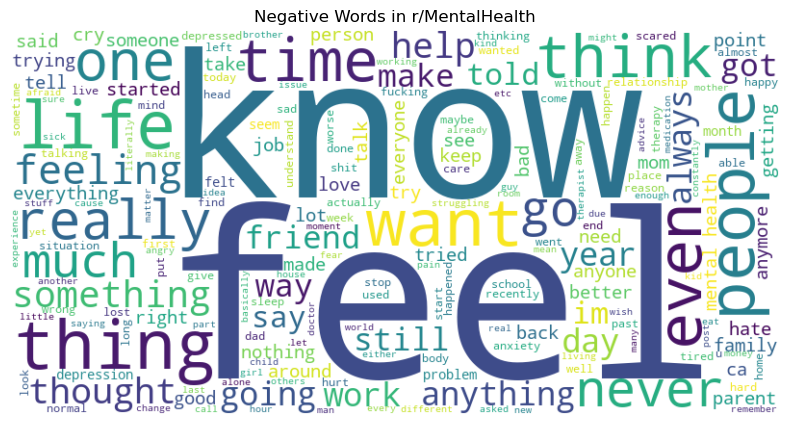

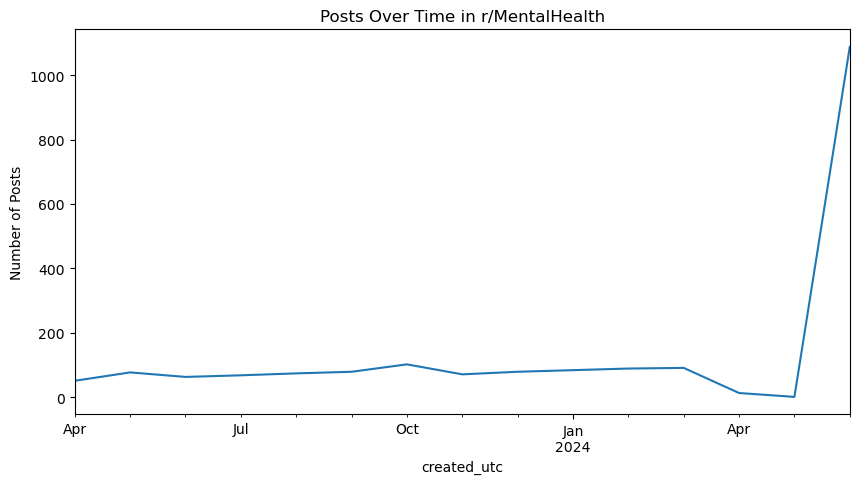


Descriptive Statistics for r/MentalHealth:
Numerical Statistics:
              score  upvote_ratio  num_comments      upvotes    downvotes  \
count  2030.000000   2030.000000   2030.000000  2030.000000  2030.000000   
mean     56.006897      0.953867     31.998030    58.806442     2.799545   
std      93.792137      0.092507     56.492632    97.700697     6.401386   
min       0.000000      0.260000      0.000000     0.000000     0.000000   
25%       1.000000      0.950000      1.000000     1.000000     0.000000   
50%      13.000000      0.990000      8.000000    13.414894     0.010101   
75%      70.000000      1.000000     43.000000    73.630505     2.632385   
max     924.000000      1.000000    616.000000   942.857143    61.487179   

       upvotes/subscribers  
count          2030.000000  
mean              0.000125  
std               0.000208  
min               0.000000  
25%               0.000002  
50%               0.000029  
75%               0.000157  
max             

In [35]:
# r/MentalHealth subreddit
mental_health_numerical_stats, mental_health_token_count_stats, mental_health_common_words = analyze_subreddit(mental_health_df)
mental_health_sentiment_stats, mental_health_sentiment_category_counts = analyze_sentiments(mental_health_df)
mental_health_topics = topic_modeling(mental_health_df['tokens'].tolist())

# word cloud for r/MentalHealth subreddit
positive_words = [token for tokens, sentiment in zip(mental_health_df['tokens'], mental_health_df['sentiment_category']) if sentiment == 'positive' for token in tokens]
neutral_words = [token for tokens, sentiment in zip(mental_health_df['tokens'], mental_health_df['sentiment_category']) if sentiment == 'neutral' for token in tokens]
negative_words = [token for tokens, sentiment in zip(mental_health_df['tokens'], mental_health_df['sentiment_category']) if sentiment == 'negative' for token in tokens]

generate_word_cloud(positive_words, "Positive Words in r/MentalHealth")
generate_word_cloud(neutral_words, "Neutral Words in r/MentalHealth")
generate_word_cloud(negative_words, "Negative Words in r/MentalHealth")

# time series analysis for r/MentalHealth subreddit
plot_time_series(mental_health_df, "Posts Over Time in r/MentalHealth")

# print statistics for r/MentalHealth subreddit
print("\nDescriptive Statistics for r/MentalHealth:")
print("Numerical Statistics:\n", mental_health_numerical_stats)
print("\nToken Count Statistics:\n", mental_health_token_count_stats)
print("\nMost Common Words:\n", mental_health_common_words)
print("\nSentiment Statistics:\n", mental_health_sentiment_stats)
print("\nSentiment Category Counts:\n", mental_health_sentiment_category_counts)

In [36]:
# save processed dataframes to CSV files
mental_health_support_df.to_csv('data/mental_health_support_cleaned.csv', index=False)
mental_health_df.to_csv('data/mental_health_cleaned.csv', index=False)

In [37]:
# combine both df into one
mental_health_support_df.reset_index(inplace=True)
mental_health_df.reset_index(inplace=True)

df = pd.concat([mental_health_support_df, 
                mental_health_df], 
               ignore_index=True)

# save processed dataframes to CSV files
df.to_csv('data/reddit_posts_cleaned.csv', index=False)

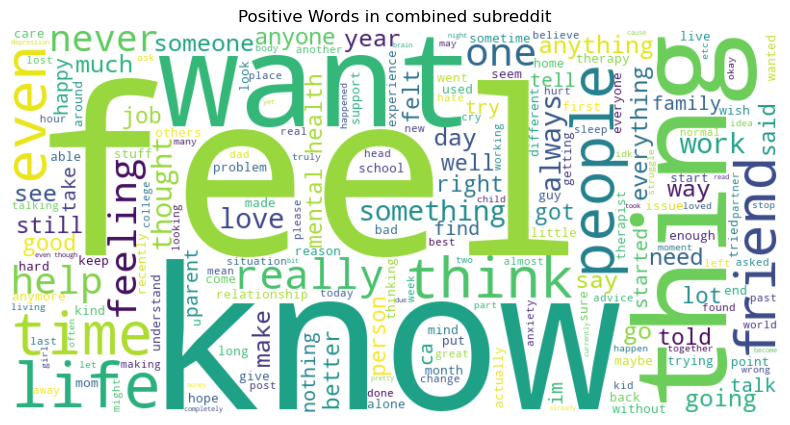

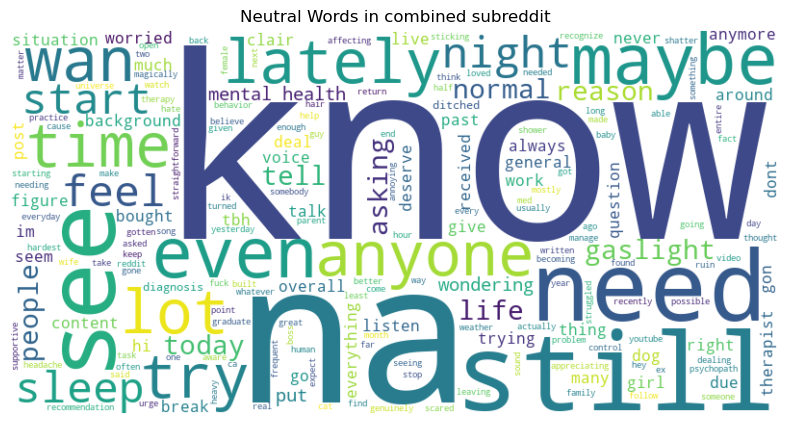

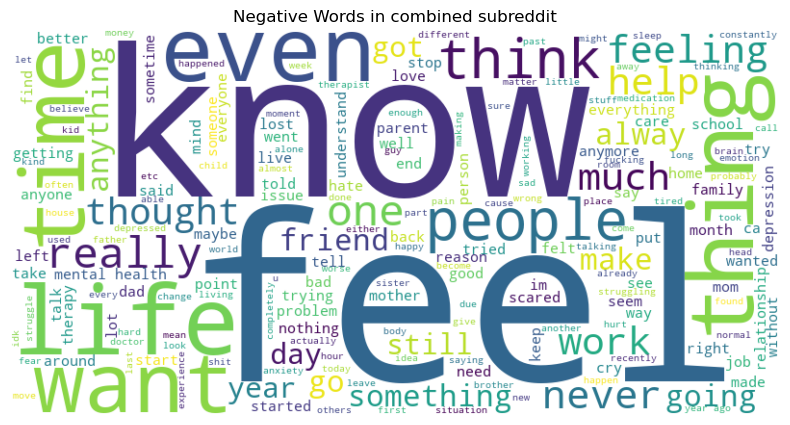

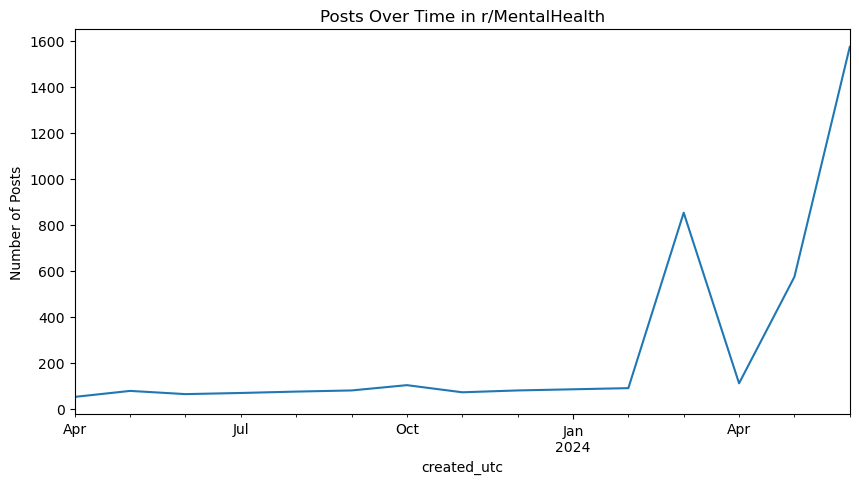


Descriptive Statistics for combined subreddit:
Numerical Statistics:
              score  upvote_ratio  num_comments      upvotes    downvotes  \
count  3945.000000   3945.000000   3945.000000  3945.000000  3945.000000   
mean     30.190368      0.962631     17.510266    31.693610     1.503243   
std      72.411462      0.085814     43.340425    75.510455     4.787981   
min       0.000000      0.260000      0.000000     0.000000     0.000000   
25%       1.000000      0.970000      0.000000     1.000000     0.000000   
50%       2.000000      1.000000      1.000000     2.000000     0.000000   
75%      31.000000      1.000000     13.000000    33.333333     0.813953   
max     924.000000      1.000000    616.000000   942.857143    61.487179   

       upvotes/subscribers  
count          3945.000000  
mean              0.000095  
std               0.000170  
min               0.000000  
25%               0.000015  
50%               0.000040  
75%               0.000111  
max         

In [38]:
# combined subreddit
df_numerical_stats, df_token_count_stats, df_common_words = analyze_subreddit(df)
df_sentiment_stats, df_sentiment_category_counts = analyze_sentiments(df)
df_topics = topic_modeling(df['tokens'].tolist())

# word cloud for r/MentalHealth subreddit
positive_words = [token for tokens, sentiment in zip(df['tokens'], df['sentiment_category']) if sentiment == 'positive' for token in tokens]
neutral_words = [token for tokens, sentiment in zip(df['tokens'], df['sentiment_category']) if sentiment == 'neutral' for token in tokens]
negative_words = [token for tokens, sentiment in zip(df['tokens'],df['sentiment_category']) if sentiment == 'negative' for token in tokens]

generate_word_cloud(positive_words, "Positive Words in combined subreddit")
generate_word_cloud(neutral_words, "Neutral Words in combined subreddit")
generate_word_cloud(negative_words, "Negative Words in combined subreddit")

# time series analysis for combined subreddit
plot_time_series(df, "Posts Over Time in r/MentalHealth")

# print statistics for r/MentalHealth subreddit
print("\nDescriptive Statistics for combined subreddit:")
print("Numerical Statistics:\n", df_numerical_stats)
print("\nToken Count Statistics:\n", df_token_count_stats)
print("\nMost Common Words:\n", df_common_words)
print("\nSentiment Statistics:\n", df_sentiment_stats)
print("\nSentiment Category Counts:\n", df_sentiment_category_counts)